In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
DATASET_PATH = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


#I- Dataset creation:
1. Get raw face dataset or make it
2. If needed crop images arround face
3. Add key points manually in a CSV file *(with FastAnnotation)*

For this project I am going to use <a href='https://www.kaggle.com/datasets/jessicali9530/lfw-dataset'>Labelled Faces in the Wild Dataset</a> and then put annotations on 400 images only *(this is a toy project)*.

*(Note: You should have consistency between the way you crop images in the dataset creation and testing in order for the algorithm to work well)*

#II- Training:
1. Load CSV file and get (x,y) coordinates in one array X as follow (x1;y1;x2;y2)...
2. Separate training data and validation data (90%/10%)
3. Make the model Custom CNN -> Fully Connected Layers -> 5 key points (x,y) (Dense 10 linear) (Loss = MSE)
4. Train it...

#III- Test !

#IV- Inference:
*(Inference is done in a separate python file)*
1. Get the camera view
2. Crop image arround faces
3. Run the algorithm on every faces each frames *(or make it a bit slower...)*
4. Show key-points in real time

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

TARGET_SHAPE = (250, 250)
NBR_KEYPOINTS = 5

def preprocess_image(filename):
    """
    Load the specified image, preprocess it and resize it to the target shape.
    """
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.math.divide(img, 255)
    img = tf.image.resize(img, TARGET_SHAPE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

dataKP = pd.read_csv(DATASET_PATH+'keyPoints.csv')

In [ ]:
from sklearn.model_selection import train_test_split

dataset_x = []; dataset_y = []

for ind in range(len(dataKP)//NBR_KEYPOINTS):
  dataset_x.append(DATASET_PATH+'400_imgs/'+dataKP['image_id'][ind*NBR_KEYPOINTS])
  tmp = []
  for i in range(NBR_KEYPOINTS):
    tmp.append(dataKP['x'][(ind*NBR_KEYPOINTS)+i])
    tmp.append(dataKP['y'][(ind*NBR_KEYPOINTS)+i])
  dataset_y.append(tmp)

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)

x_train, x_val, y_train, y_val = train_test_split(dataset_x, dataset_y, test_size=0.1)

print(dataset_x.shape, dataset_y.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

del(dataset_x)
del(dataset_y)

(400,) (400, 10)
(360,) (360, 10)
(40,) (40, 10)


In [ ]:
from sklearn.utils import shuffle

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, x2, batch_size, shuffle=True):
        'Initialization'
        self.x = x
        self.x2 = x2
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'

        x1_batch_tmp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        x2_batch_tmp = self.x2[index*self.batch_size:(index+1)*self.batch_size]
        x1_batch = []; x2_batch = []
        coef_resize_x = 1; coef_resize_y = 1
        for i in range(len(x1_batch_tmp)):
          img = tf.io.read_file(x1_batch_tmp[i])
          img = tf.image.decode_jpeg(img, channels=3)
          coef_resize_x = (TARGET_SHAPE[0]/img.shape[0])
          coef_resize_y = (TARGET_SHAPE[1]/img.shape[1])
          img = tf.math.divide(img, 255)
          img = tf.image.resize(img, TARGET_SHAPE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
          x1_batch.append(img)
          tmp = []
          for y in range(NBR_KEYPOINTS):
            tmp.append(int(x2_batch_tmp[i][y*2]*coef_resize_x))
            tmp.append(int(x2_batch_tmp[i][(y*2)+1]*coef_resize_y))
          x2_batch.append(tmp)
        x1_batch = np.array(x1_batch)
        x2_batch = np.array(x2_batch)

        return x1_batch, x2_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.x2 = shuffle(self.x, self.x2)

train_gen = DataGenerator(x_train, y_train, batch_size=8, shuffle=True)
val_gen = DataGenerator(x_val, y_val, batch_size=8, shuffle=False)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

def Get_Model():
  model = Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=TARGET_SHAPE+(3,)),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2), strides=2),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2), strides=2),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NBR_KEYPOINTS*2) ]) #(x,y) coords*NBR_KEYPOINTS
  model.summary()
  return model
    
model = Get_Model()

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 128)      0

In [ ]:
history = model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=30)

Epoch 1/30
45/45 [==============================] - 84s 2s/step - loss: 9227.7461 - val_loss: 2051.5620
Epoch 2/30
45/45 [==============================] - 49s 1s/step - loss: 4063.8867 - val_loss: 721.2332
Epoch 3/30
45/45 [==============================] - 49s 1s/step - loss: 2902.9563 - val_loss: 112.3664
Epoch 4/30
45/45 [==============================] - 49s 1s/step - loss: 2199.1006 - val_loss: 83.4966
Epoch 5/30
45/45 [==============================] - 49s 1s/step - loss: 1728.6838 - val_loss: 401.6630
Epoch 6/30
45/45 [==============================] - 49s 1s/step - loss: 1442.8209 - val_loss: 277.1626
Epoch 7/30
45/45 [==============================] - 49s 1s/step - loss: 1375.5446 - val_loss: 47.7572
Epoch 8/30
45/45 [==============================] - 48s 1s/step - loss: 1253.6454 - val_loss: 481.4713
Epoch 9/30
45/45 [==============================] - 49s 1s/step - loss: 1234.7351 - val_loss: 298.7372
Epoch 10/30
45/45 [==============================] - 50s 1s/step - loss: 1

In [ ]:
model.save('/content/gdrive/MyDrive/saved_model')

In [ ]:
'''
Download the directory saved_model on your computer for local inference.
Check the download directory.
'''

from google.colab import files
import shutil
import os

def make_archive(source, destination):
    base = os.path.basename(destination)
    name = base.split('.')[0]
    format = base.split('.')[1]
    archive_from = os.path.dirname(source)
    archive_to = os.path.basename(source.strip(os.sep))
    shutil.make_archive(name, format, archive_from, archive_to)
    shutil.move('%s.%s'%(name,format), destination)

make_archive('/content/gdrive/MyDrive/saved_model', '/content/saved_model.zip')

files.download(f'/content/saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

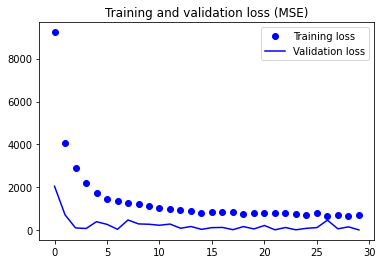

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(30)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (MSE)')
plt.legend()
plt.show()

/content/gdrive/MyDrive/400_imgs/Ali_Bin_Hussein_0001.jpg
[103. 113. 144. 113. 128. 135. 111. 158. 136. 161.]
1/1 [==============================] - 0s 64ms/step


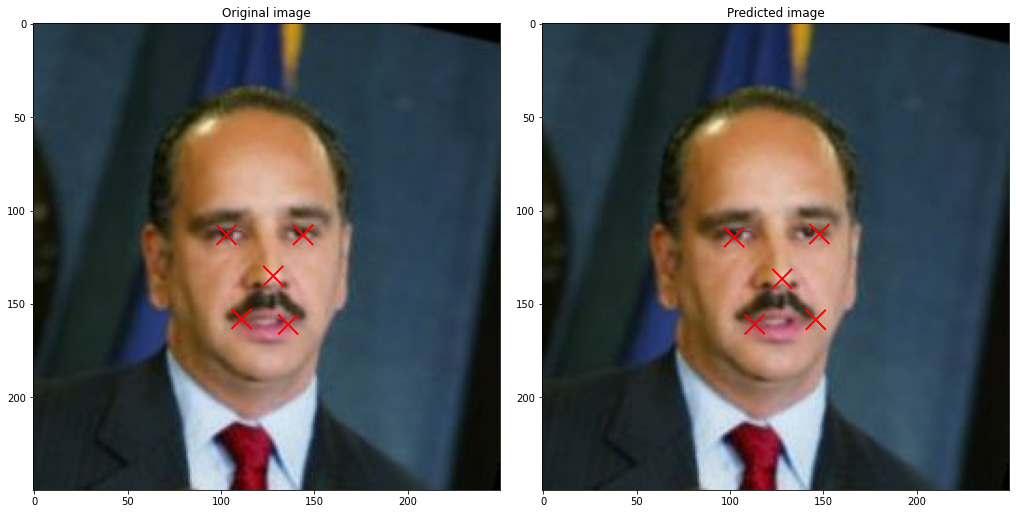

In [ ]:
import random

rnd = random.randint(0, x_val.shape[0])
print(x_val[rnd])
print(y_val[rnd])

randomImage = preprocess_image(x_val[rnd])
randomImage = np.expand_dims(randomImage, axis=0)

pred_y = model.predict(randomImage)[0]

fig, ax = plt.subplots(1, 2,figsize=(14, 1*7), constrained_layout=True)

ax[0].set_title('Original image')
for i in range(NBR_KEYPOINTS):
  ax[0].plot([y_val[rnd][i*2]+5, y_val[rnd][i*2]-5], [y_val[rnd][(i*2)+1]+5, y_val[rnd][(i*2)+1]-5], color="red", linewidth=2)
  ax[0].plot([y_val[rnd][i*2]+5, y_val[rnd][i*2]-5], [y_val[rnd][(i*2)+1]-5, y_val[rnd][(i*2)+1]+5], color="red", linewidth=2)
ax[0].imshow(randomImage[0])

ax[1].set_title('Predicted image')
for i in range(NBR_KEYPOINTS):
  ax[1].plot([pred_y[i*2]+5, pred_y[i*2]-5], [pred_y[(i*2)+1]+5, pred_y[(i*2)+1]-5], color="red", linewidth=2)
  ax[1].plot([pred_y[i*2]+5, pred_y[i*2]-5], [pred_y[(i*2)+1]-5, pred_y[(i*2)+1]+5], color="red", linewidth=2)
ax[1].imshow(randomImage[0])